In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Attention, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Time-Series-Forecasting

## 4. Data Processing

### 4.1. Load historical Bitcoin price data

The historical Bitcoin price data were downloaded from the **Coinbase API**. The dataset contains the price data for **1 year**, from **November 2023** to **October 2024**.

In [2]:
btc_price_data_1_year = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
btc_price_data_1_year

,timestamp,open,high,low,close,volume
0,2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
1,2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2,2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
3,2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
4,2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...,...
527180,2025-01-23 23:56:00,104047.01,104112.45,104064.68,104079.63,6.922352
527181,2025-01-23 23:57:00,104052.01,104088.97,104079.63,104079.60,1.628341
527182,2025-01-23 23:58:00,103928.31,104088.89,104079.60,103964.62,10.861781
527183,2025-01-23 23:59:00,103900.00,103973.87,103964.62,103926.36,6.802193


In [3]:
# get hourly data
#btc_price_data_1_year[0::60]

In [4]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,527185.0,69423.311389,15429.285709,39503.000000,60757.240000,65736.790000,70694.260000,108768.040000
high,527185.0,69484.281813,15445.681849,39544.660000,60803.890000,65783.580000,70750.800000,109358.010000
low,527185.0,69453.742158,15437.450474,39533.470000,60780.210000,65760.090000,70723.790000,108954.900000
close,527185.0,69454.050246,15437.463194,39533.480000,60780.690000,65760.220000,70723.000000,108951.030000
volume,527185.0,8.978855,16.369091,0.000166,1.669723,3.956193,9.717255,1047.117525


In [5]:
btc_price_data_1_year.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

In [6]:
btc_price_data_1_year.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

### 4.2. Data Tidying and Cleaning

Convert the `timestamp` column from *object* type to *datetime64* type.

In [7]:
btc_price_data_1_year.timestamp = pd.to_datetime(btc_price_data_1_year.timestamp)

In [8]:
btc_price_data_1_year.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume              float64
dtype: object

Set `timestamp` as index.

In [9]:
btc_price_data_1_year.set_index('timestamp', inplace=True, drop = True)

In [10]:
# Ensure the data is sorted by time
btc_price_data_1_year = btc_price_data_1_year.sort_index()

In [11]:
btc_price_data_1_year

,open,high,low,close,volume
timestamp,,,,,
2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...
2025-01-23 23:56:00,104047.01,104112.45,104064.68,104079.63,6.922352
2025-01-23 23:57:00,104052.01,104088.97,104079.63,104079.60,1.628341
2025-01-23 23:58:00,103928.31,104088.89,104079.60,103964.62,10.861781


#### Extract only the daily data

To filter your hourly dataset and extract only the daily data (e.g., one row per day), you can aggregate the hourly data based on a specific column (like close) using groupby operations. Here's how you can do it:

Option 1: Aggregate by Day
If you want to summarize the data to daily values (e.g., daily open, high, low, close, volume):

In [12]:
# # Ensure the datetime column is a datetime object
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# # Set the datetime column as the index
# df.set_index('timestamp', inplace=True)

# Resample the data to daily frequency
# daily_df = btc_price_data_1_year.resample('D').agg({
#     'open': 'first',  # First hour's open price
#     'high': 'max',    # Daily high
#     'low': 'min',     # Daily low
#     'close': 'last',  # Last hour's close price
#     'volume': 'sum'   # Sum of volumes
# }).dropna()

# print(daily_df.head())

### 4.3. Plot Bitcoin Price

In [13]:
def plot_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    x_lim_start = dates[0]
    x_lim_end = dates[len(dates) - 1]
    # plt.xlim(x_lim_start, x_lim_end)
    ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates, prices)
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.show()

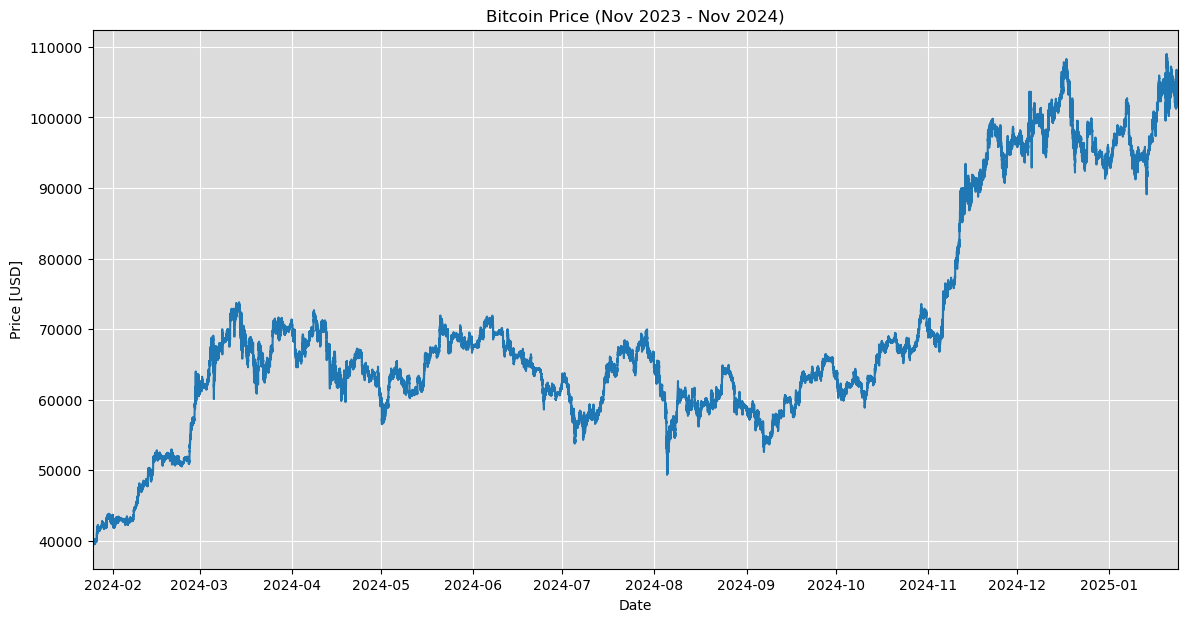

In [14]:
dates = btc_price_data_1_year.index
prices_close_btc = btc_price_data_1_year.close
title_btc = 'Bitcoin Price (Nov 2023 - Nov 2024)'

labels = ['Date', 'Price [USD]']

plot_market_data(dates, prices_close_btc, labels, title_btc)

## 5. Feature Engineering

### 5.1. Seasonality and Trends

#### 5.1.1. Add Time-Based Features

We extract various components of the datetime, such as the **month**, **day**, **hour**, and **day of the week**. This can help the model capture seasonality and trends.

In [15]:
btc_price_data_1_year['month'] = btc_price_data_1_year.index.month.astype('float64')
btc_price_data_1_year['day'] = btc_price_data_1_year.index.day.astype('float64')
btc_price_data_1_year['weekday'] = btc_price_data_1_year.index.weekday.astype('float64')  # Monday=0, Sunday=6
btc_price_data_1_year['hour'] = btc_price_data_1_year.index.hour.astype('float64')

For time-based features like **hour of day** and **day of the week**, we can use **cyclical encoding**. This ensures that values like 23:00 and 00:00 are considered "close" to each other, rather than being far apart numerically.

In [16]:
# Extract hour and weekday
btc_price_data_1_year['hour_sin'] = np.sin(2 * np.pi * btc_price_data_1_year.index.hour / 24)  # Hour sin encoding
btc_price_data_1_year['hour_cos'] = np.cos(2 * np.pi * btc_price_data_1_year.index.hour / 24)  # Hour cos encoding
btc_price_data_1_year['weekday_sin'] = np.sin(2 * np.pi * btc_price_data_1_year.index.weekday / 7)  # Weekday sin encoding
btc_price_data_1_year['weekday_cos'] = np.cos(2 * np.pi * btc_price_data_1_year.index.weekday / 7)  # Weekday cos encoding

#### 5.1.2. STL (Seasonal-Trend decomposition using LOESS)

**STL** stands for **Seasonal-Trend decomposition using LOESS**. It's a robust statistical method used to decompose a time series into three components:

1. **Seasonal Component**: Represents the repeating pattern in the data over a fixed period (e.g., daily, weekly, monthly).
2. **Trend Component**: Captures the long-term progression in the data, showing an overall increase, decrease, or stability over time.
3. **Remainder/Residual Component**: Represents the part of the data that cannot be attributed to either seasonality or trend, often considered as noise.

**Key Features of STL**
- **Flexible**: Allows decomposition of time series with any type of seasonal pattern, not limited to a fixed frequency.
- **Robust**: Resistant to outliers in the data.
- **Local Regression (LOESS)**: Uses locally weighted regression to smooth the data during decomposition.

**Applications**
- **Forecasting**: By isolating the trend and seasonal components, forecasting models can be more accurate.
- **Anomaly Detection**: The remainder component helps identify unusual spikes or dips.
- **Visualization**: Simplifies understanding of the data by breaking it into interpretable parts.

In [17]:
# Apply STL decomposition
stl = STL(btc_price_data_1_year['close'], robust=True, period = 24)  # period=24 for daily seasonality in hourly data
result = stl.fit()

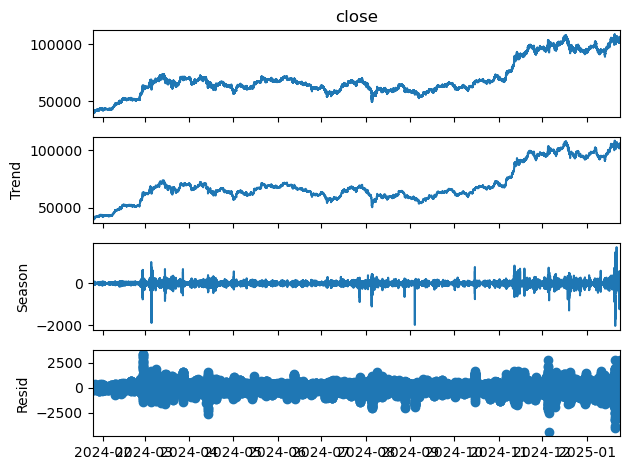

In [18]:
# Extract components
btc_price_data_1_year['trend'] = result.trend
btc_price_data_1_year['seasonal'] = result.seasonal
btc_price_data_1_year['residual'] = result.resid

# Plot the decomposition
result.plot()
plt.show()

In [19]:
# 1.Lagged Features - Lagged values of the trend, seasonal, and residual
for lag in range(1, 4):  # Use 1, 2, 3 hours as lags
    btc_price_data_1_year[f'trend_lag_{lag}'] = btc_price_data_1_year['trend'].shift(lag)
    btc_price_data_1_year[f'seasonal_lag_{lag}'] = btc_price_data_1_year['seasonal'].shift(lag)
    btc_price_data_1_year[f'residual_lag_{lag}'] = btc_price_data_1_year['residual'].shift(lag)

# 2.Rolling Statistics - Rolling mean and standard deviation of each component.
btc_price_data_1_year['trend_rolling_mean'] = btc_price_data_1_year['trend'].rolling(window=24).mean()
btc_price_data_1_year['residual_rolling_std'] = btc_price_data_1_year['residual'].rolling(window=24).std()

# 3.Differences - Calculate the difference between close price and its trend or seasonality
btc_price_data_1_year['close_trend_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['trend']
btc_price_data_1_year['close_seasonal_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['seasonal']

#### 5.1.3. Rolling Statistics

Rolling mean and standard deviation help capture local trends and volatility.

In [20]:
# Rolling windows in hours
windows = [6, 12, 24]

In [21]:
# Rolling statistics for 'close' price
for window in windows:
    btc_price_data_1_year[f'close_roll_mean_{window}'] = btc_price_data_1_year['close'].rolling(window=window).mean()
    btc_price_data_1_year[f'close_roll_std_{window}'] = btc_price_data_1_year['close'].rolling(window=window).std()

Volume data can indicate market activity or interest

In [22]:
# Volume-based rolling statistics
for window in windows:
    btc_price_data_1_year[f'volume_roll_mean_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).mean()
    btc_price_data_1_year[f'volume_roll_std_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).std()

### 5.2. Autocorrelation

Autocorrelation in time series refers to the correlation of a time series with a lagged version of itself. It measures how past values of the series influence current values. Understanding autocorrelation can help identify patterns, trends, and periodicity in time-series data.

##### Why Autocorrelation Matters
- **Pattern Detection**: Helps identify repeating patterns or seasonality.
- **Modeling Assumptions**: Many models (like ARIMA) assume specific autocorrelation structures.
- **Feature Engineering**: Insights from autocorrelation can guide the creation of lag-based features for machine learning models.

##### Types of Autocorrelation
1. **Positive Autocorrelation**: High values follow high values, and low values follow low values.
2. **Negative Autocorrelation**: High values follow low values, and vice versa.
3. **No Autocorrelation**: Values are independent of each other.

##### How to Measure Autocorrelation
The **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** are two common tools:

###### 1. **Autocorrelation Function (ACF)**
- Measures the correlation between the time series and its lagged values.
- Useful for identifying the overall pattern of dependence at different lags.

###### 2. **Partial Autocorrelation Function (PACF)**
- Measures the correlation between the time series and its lagged values after removing the influence of shorter lags.
- Useful for determining the direct relationship between a value and a specific lag.


#### 5.2.1. Autocorrelation Function (ACF)

Set the count of the **lags** that will be considered during the Autocorrelation anylysis:

In [23]:
# We use the last 3 days (3 * 24 hours) for the autocorrelation analysis
lags = 72

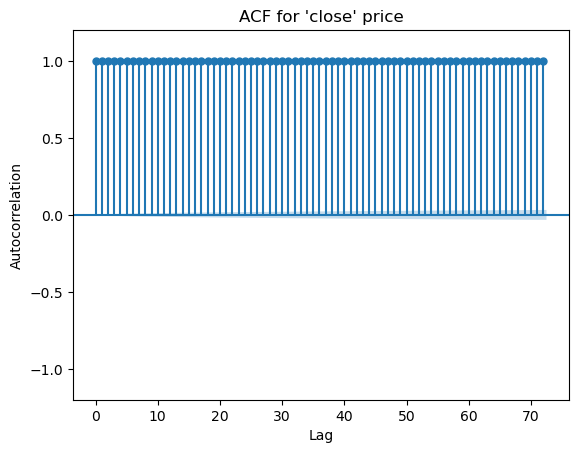

In [24]:
plot_acf(btc_price_data_1_year.close, lags = lags)
plt.ylim(-1.2, 1.2)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF for \'close\' price')
plt.show()

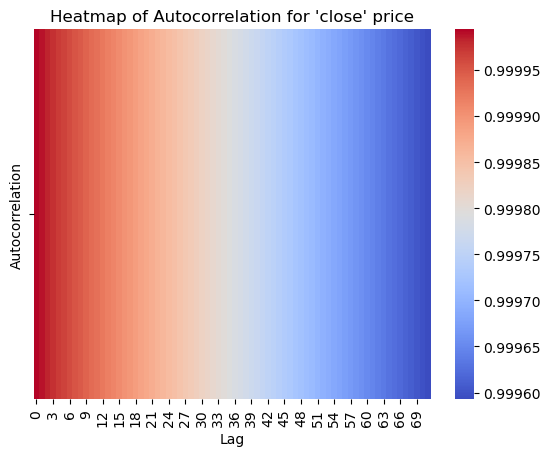

In [25]:
autocorr = [btc_price_data_1_year['close'].autocorr(lag) for lag in range(1, lags+1)]
sns.heatmap(pd.DataFrame(autocorr, columns=["Autocorrelation"]).T, annot=False, cmap="coolwarm")
plt.xlabel('Lag')
plt.title('Heatmap of Autocorrelation for \'close\' price')
plt.show()

Because the **autocorrelation** is very large we use **partial autocorrelation**.

#### 5.2.2. Partial Autocorrelation Function (PACF)

The **Partial Autocorrelation Function (PACF)** measures the partial correlation of a stationary time series with its own lagged values, accounting for the influence of intermediate lags. Unlike the **Autocorrelation Function (ACF)**, which considers all previous lags, the PACF isolates the direct relationship between a variable and its lags.

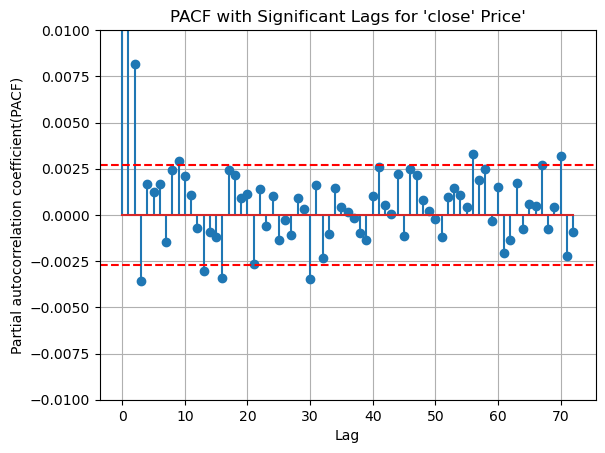

Significant Lags: [ 0  1  2  3  9 13 16 30 56 67 70]


In [26]:
# Calculate PACF
pacf_values = pacf(btc_price_data_1_year['close'], nlags=lags)

# Calculate the confidence interval
conf_int = 1.96 / np.sqrt(len(btc_price_data_1_year['close']))  # The 95% confidence interval

# Get significant lags (values outside the confidence interval)
significant_lags = np.where(np.abs(pacf_values) > conf_int)[0]

# Plot PACF with significant lags marked
plt.stem(pacf_values)

plt.axhline(y=conf_int, color='r', linestyle='--')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.ylim(-0.010, 0.010)

plt.grid()

plt.xlabel('Lag')
plt.ylabel('Partial autocorrelation coefficient(PACF)')
plt.title("PACF with Significant Lags for \'close\' Price'")
plt.show()

# Print the significant lags
print("Significant Lags:", significant_lags)

**Significant lags**: Spikes that are outside the area between the two red lines are **statistically significant** at the 95% confidence level.

Correlation coefficients that are between the two red lines are **insignificant** for the model. In this area the **p-value** is too small. Correlations in this area may well be random.

In [27]:
# Remove the autocorrelation with itself (the '0'-th lag)
significant_lags = significant_lags[1:] if significant_lags[0] == 0 else significant_lags
print("Significant Lags:", significant_lags)

Significant Lags: [ 1  2  3  9 13 16 30 56 67 70]


In [28]:
# Create lag features (past values as features)
def create_lag_features(df, lags = []):
    """
    Create lag features (past values as features)
    """
    # Create a copy of the DataFrame
    df_copy = df.copy(deep=True)
    
    for lag in lags:
        df_copy[f'lag_{lag}'] = df_copy['close'].shift(lag)
        
    #df.dropna(inplace=True)
    return df_copy

In [29]:
btc_price_data_1_year = create_lag_features(btc_price_data_1_year, significant_lags)

### 5.3. Calculate Technical Indicators

#### 5.3.1. Relative Strength Index (RSI)

**RSI** is a momentum oscillator that measures the speed and change of recent price movements. It is used to identify overbought or oversold conditions in a stock's price, generally over a 14-day period.

- **Formula**: The RSI is calculated as:
  
  $$\text{RSI} = 100 - \frac{100}{1 + RS}$$
  
  where $RS$ (Relative Strength) is the ratio of **average gains** to **average losses** over the lookback period (e.g., 14 days).

- **Interpretation**:
  - **Overbought Condition**: When RSI is above 70, the asset is often considered overbought, suggesting a potential for a pullback.
  - **Oversold Condition**: When RSI is below 30, the asset is considered oversold, suggesting a potential for a rebound.

- **Calculation**:
  - Calculate the **change** in price from one day to the next.
  - Separate the changes into **gains** (positive changes) and **losses** (negative changes).
  - Compute the **average gain** and **average loss** over the 14-day period.
  - Calculate \( RS \) as the ratio of average gain to average loss.
  - Use the RSI formula to convert \( RS \) into an index between 0 and 100.

In [30]:
def calculate_rsi(data, window=14):
    """
    RSI is a momentum oscillator that measures the speed and change of price movements, typically over a 14-period interval.
    Assuming 'data' is a DataFrame with a 'close' price column

    Parameters
    ----------
    data:   a DataFrame with the time series data. A column with the name 'close' must be present in the DataFrame! 
            This column is used to calculate the 'RSI' value.
    window: the time period that is taken into account when calculating the 'RSI'
    """
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    
    return data

In [31]:
# Calculate RSI
btc_price_data_1_year = calculate_rsi(btc_price_data_1_year)

#### 5.3.2. Moving Average Convergence Divergence (MACD)

**MACD** is a trend-following momentum indicator that shows the relationship between two moving averages of an asset’s price.

- **Formula**:
  - **MACD Line**: $\text{MACD} = \text{EMA}_{\text{short}} - \text{EMA}_{\text{long}}$
  - **Signal Line**: A **9-day EMA** of the MACD line.
  - **MACD Histogram**: The difference between the MACD line and the Signal Line.

  Here, EMA stands for Exponential Moving Average, which gives more weight to recent prices.

- **Common Parameters**:
  - **Short EMA**: Often set to a 12-day EMA.
  - **Long EMA**: Often set to a 26-day EMA.
  - **Signal Line EMA**: Often set to a 9-day EMA of the MACD line.

- **Interpretation**:
  - **MACD Line Crosses Above Signal Line**: This is a bullish signal, indicating a potential buy.
  - **MACD Line Crosses Below Signal Line**: This is a bearish signal, indicating a potential sell.
  - **MACD Divergence**: If the price and MACD are moving in opposite directions, it may signal a reversal.
  - **Histogram**: The MACD histogram shows the distance between the MACD line and the Signal Line. When the histogram grows larger, it indicates a strengthening trend in that direction.

- **Application**:
  - The MACD helps traders see changes in momentum, trend direction, and possible reversal points by analyzing the difference between the short and long EMAs.

In [32]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Moving Average Convergence Divergence (MACD) is calculated using two exponential moving averages (EMA):
    the 12-day EMA and the 26-day EMA, with a 9-day EMA as the signal line.
    """
    data['EMA12'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD Line
    data['MACD'] = data['EMA12'] - data['EMA26']
    
    # Signal Line
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    return data

In [33]:
# Calculate MACD (Moving Average Convergence Divergence)
btc_price_data_1_year = calculate_macd(btc_price_data_1_year)

#### 5.3.3. Moving Averages (SMA and EMA)

Moving averages smooth out price data to help identify trends over specific time frames. They are often used to see the underlying trend of an asset’s price and are among the most widely used technical indicators.

##### 2.2.3.1. Simple Moving Average (SMA)

- **Definition**: The **SMA** is the average of the closing prices over a specific period. For example, a 10-day SMA is the average closing price over the last 10 days.
  
- **Formula**:
  $$\text{SMA} = \frac{\sum_{i=1}^{N} \text{Price}_i}{N}$$
  where $N$ is the period (e.g., 10 days).

- **Interpretation**:
  - **Trend Identification**: When prices are above the SMA, it suggests an upward trend; when below, it suggests a downward trend.
  - **Crossovers**: When a short-term SMA crosses above a long-term SMA (e.g., 10-day SMA crosses above the 50-day SMA), it generates a bullish signal. The reverse crossover indicates a bearish signal.

##### 2.2.3.2. Exponential Moving Average (EMA)

- **Definition**: The **EMA** is a weighted moving average that gives more importance to recent prices, making it more responsive to new information than the SMA.
  
- **Formula**:
  - EMA uses a multiplier:
    $$\text{EMA}_\text{current} = \left(\frac{2}{N+1}\right) \times (\text{Price}_\text{current} - \text{EMA}_\text{previous}) + \text{EMA}_\text{previous}$$
    where $N$ is the number of periods.

- **Interpretation**:
  - **More Sensitive to Price Changes**: Because the EMA responds more quickly to recent prices, it is useful in identifying potential reversals and shorter-term trends.

In [34]:
def calculate_moving_averages(data, sma_window=20, ema_window=20):
    """
    Simple Moving Average (SMA) is the average price over a specified number of periods, 
    while Exponential Moving Average (EMA) gives more weight to recent prices.
    """
    # Simple Moving Average
    data['SMA'] = data['close'].rolling(window=sma_window).mean()
    
    # Exponential Moving Average
    data['EMA'] = data['close'].ewm(span=ema_window, adjust=False).mean()
    
    return data

In [35]:
# Calculate moving averages
btc_price_data_1_year = calculate_moving_averages(btc_price_data_1_year)

## 6. Calculate Target Variable

The **target** variable will be derived from the **technical indicators**. The values of this variable are used as **buy/sell signals** for the traiding strategy. 

There will be 3 target values:
* -1 - sell
* 0  - do nothing
* 1  - buy

In [36]:
def create_target_variable_with_techn_indicators_hourly(data, price_threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100
    
    # Use the technical indicators to add more conditions to the target:
    # - RSI: A Relative Strength Index (RSI) value below 30 often indicates an oversold condition, which might suggest a buying opportunity.
    # - MACD: A positive MACD value (i.e., MACD > Signal Line) can suggest an uptrend.
    # - SMA/EMA: If the current price is above the SMA or EMA, it may indicate an upward trend.
    #data_copy['buy_signal'] = (
    conditions_buy  = (
        (data_copy['future_return'] > price_threshold) &
        #(data_copy['RSI'] < 30) &   # buy signal for RSI
        (data_copy['RSI'] < 40) &    # buy signal for RSI
        ((data_copy['MACD'] > data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) <= data_copy['Signal_Line'].shift(1))) #& # buy signal for MACD
        # ((data_copy['close'] > data_copy['SMA']) & (data_copy['close'].shift(1) <= data_copy['SMA'].shift(1))) # buy signal for SMA
    ).astype(int)

    conditions_sell  = (
        (data_copy['future_return'] < - price_threshold) &
        #(data_copy['RSI'] > 70) &    # sell signal for RSI 
        (data_copy['RSI'] > 60) &     # sell signal for RSI 
        (data_copy['MACD'] < data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) >= data_copy['Signal_Line'].shift(1)) #& # sell signal for MACD 
        # (data_copy['close'] < data_copy['SMA']) & (data_copy['close'].shift(1) >= data_copy['SMA'].shift(1)) # sell signal for SMA 
    ).astype(int)

    # Define the 'target' as 1 (buy), 0(do nothing) and 2(sell).
    # Initialize the 'target' column with default value
    data_copy['target'] = 0 # 'do nothing' signal
    
    # Fill the 'target' with the 'buy_signal' and 'sell_signal' conditions 
    data_copy.loc[(conditions_buy == 1) & (conditions_sell == 0), 'target'] = 1 # 'buy' signal
    data_copy.loc[(conditions_sell == 1) & (conditions_buy == 0), 'target'] = 2 # 'sell' signal

    # Generate signals
    # data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    # data['signal'] = data['signal'].diff()  # 1 = Buy, 2 = Sell

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    # data_copy = data_copy.dropna()

    # Print the balance of 0s, 1s and 2s in our 'target' variable to understand how many 'buy' and 'sell' signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [37]:
# Define the threshold for the price change to classify as 'buy' or 'sell'. For instance, if we want a 1% increase to be a 'buy' signal,
# the threshold will be 0.01.
threshold = 0.01
#threshold = 0.005

# Compute the 'target' variable
# btc_price_data_1_year = create_target_variable_with_techn_indicators_hourly(btc_price_data_1_year, threshold)

To predict the next hour’s price, create a target column.

In [38]:
def create_target_variable_closing_hourly(data, price_threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100
    
    # Use the technical indicators to add more conditions to the target:
    # - RSI: A Relative Strength Index (RSI) value below 30 often indicates an oversold condition, which might suggest a buying opportunity.
    # - MACD: A positive MACD value (i.e., MACD > Signal Line) can suggest an uptrend.
    # - SMA/EMA: If the current price is above the SMA or EMA, it may indicate an upward trend.
    #data_copy['buy_signal'] = (
    conditions_buy  = ((data_copy['future_return'] > 0)).astype(int)
    conditions_sell  = ((data_copy['future_return'] < 0)).astype(int)

    # Define the 'target' as 1 (buy), 0(do nothing) and 2(sell).
    # Initialize the 'target' column with default value
    data_copy['target'] = 0 # 'do nothing' signal
    
    # Fill the 'target' with the 'buy_signal' and 'sell_signal' conditions 
    data_copy.loc[(conditions_buy == 1) & (conditions_sell == 0), 'target'] = 1 # 'buy' signal
    data_copy.loc[(conditions_sell == 1) & (conditions_buy == 0), 'target'] = -1 # 'sell' signal

    # Generate signals
    # data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    # data['signal'] = data['signal'].diff()  # 1 = Buy, 2 = Sell

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    # data_copy = data_copy.dropna()

    # Print the balance of 0s, 1s and 2s in our 'target' variable to understand how many 'buy' and 'sell' signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [39]:
#btc_price_data_1_year = create_target_variable_closing_hourly(btc_price_data_1_year)

In [40]:
# Target: Next hour's close price
btc_price_data_1_year['target'] = btc_price_data_1_year['close'].shift(-1)

In [41]:
# Generate target variable: 1 if price goes up, 0 if price goes down
# btc_price_data_1_year['target'] = np.where(btc_price_data_1_year['close'].shift(-1) > btc_price_data_1_year['close'], 1, 0)

In [42]:
btc_price_data_1_year['target'].value_counts()

target
64000.00     20
67000.00     17
63000.00     17
62800.00     15
69500.00     15
             ..
67229.15      1
67255.68      1
67301.85      1
67234.51      1
103889.08     1
Name: count, Length: 473079, dtype: int64

In [43]:
btc_price_data_1_year

,open,high,low,close,volume,month,day,weekday,hour,hour_sin,...,lag_67,lag_70,RSI,EMA12,EMA26,MACD,Signal_Line,SMA,EMA,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578,1.0,25.0,3.0,0.0,0.000000,...,NaN,NaN,NaN,40051.800000,40051.800000,0.000000,0.000000,NaN,40051.800000,40061.92
2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910,1.0,25.0,3.0,0.0,0.000000,...,NaN,NaN,100.000000,40053.356923,40052.549630,0.807293,0.161459,NaN,40052.763810,40042.82
2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218,1.0,25.0,3.0,0.0,0.000000,...,NaN,NaN,34.633812,40051.735858,40051.828916,-0.093058,0.110555,NaN,40051.816780,40055.80
2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071,1.0,25.0,3.0,0.0,0.000000,...,NaN,NaN,54.739336,40052.361111,40052.123071,0.238040,0.136052,NaN,40052.196134,40063.20
2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187,1.0,25.0,3.0,0.0,0.000000,...,NaN,NaN,61.491935,40054.028632,40052.943584,1.085048,0.325851,NaN,40053.244122,40052.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-23 23:56:00,104047.01,104112.45,104064.68,104079.63,6.922352,1.0,23.0,3.0,23.0,-0.258819,...,104137.62,103965.81,29.373136,104104.705340,104159.758613,-55.053273,-53.582300,104137.7735,104139.849113,104079.60
2025-01-23 23:57:00,104052.01,104088.97,104079.63,104079.60,1.628341,1.0,23.0,3.0,23.0,-0.258819,...,104062.07,104244.16,35.065829,104100.842980,104153.820938,-52.977958,-53.461431,104129.8905,104134.111102,103964.62
2025-01-23 23:58:00,103928.31,104088.89,104079.60,103964.62,10.861781,1.0,23.0,3.0,23.0,-0.258819,...,103971.10,104230.35,26.167828,104079.885599,104139.806054,-59.920455,-54.753236,104116.4745,104117.969092,103926.36


## 7. Clean up the Data

In [45]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,527185.0,69423.311389,15429.285709,39503.000000,60757.240000,6.573679e+04,70694.260000,108768.040000
high,527185.0,69484.281813,15445.681849,39544.660000,60803.890000,6.578358e+04,70750.800000,109358.010000
low,527185.0,69453.742158,15437.450474,39533.470000,60780.210000,6.576009e+04,70723.790000,108954.900000
close,527185.0,69454.050246,15437.463194,39533.480000,60780.690000,6.576022e+04,70723.000000,108951.030000
volume,527185.0,8.978855,16.369091,0.000166,1.669723,3.956193e+00,9.717255,1047.117525
month,527185.0,6.528672,3.443956,1.000000,4.000000,7.000000e+00,10.000000,12.000000
day,527185.0,15.731193,8.811791,1.000000,8.000000,1.600000e+01,23.000000,31.000000
weekday,527185.0,2.999566,1.997391,0.000000,1.000000,3.000000e+00,5.000000,6.000000
hour,527185.0,11.497469,6.921639,0.000000,5.000000,1.100000e+01,17.000000,23.000000
hour_sin,527185.0,0.000213,0.707107,-1.000000,-0.707107,1.224647e-16,0.707107,1.000000


In [46]:
btc_price_data_1_year.dtypes

open                    float64
high                    float64
low                     float64
close                   float64
volume                  float64
month                   float64
day                     float64
weekday                 float64
hour                    float64
hour_sin                float64
hour_cos                float64
weekday_sin             float64
weekday_cos             float64
trend                   float64
seasonal                float64
residual                float64
trend_lag_1             float64
seasonal_lag_1          float64
residual_lag_1          float64
trend_lag_2             float64
seasonal_lag_2          float64
residual_lag_2          float64
trend_lag_3             float64
seasonal_lag_3          float64
residual_lag_3          float64
trend_rolling_mean      float64
residual_rolling_std    float64
close_trend_diff        float64
close_seasonal_diff     float64
close_roll_mean_6       float64
close_roll_std_6        float64
close_ro

In [47]:
btc_price_data_1_year.shape

(527185, 59)

In [48]:
btc_price_data_1_year.isnull().sum()

open                     0
high                     0
low                      0
close                    0
volume                   0
month                    0
day                      0
weekday                  0
hour                     0
hour_sin                 0
hour_cos                 0
weekday_sin              0
weekday_cos              0
trend                    0
seasonal                 0
residual                 0
trend_lag_1              1
seasonal_lag_1           1
residual_lag_1           1
trend_lag_2              2
seasonal_lag_2           2
residual_lag_2           2
trend_lag_3              3
seasonal_lag_3           3
residual_lag_3           3
trend_rolling_mean      23
residual_rolling_std    23
close_trend_diff         0
close_seasonal_diff      0
close_roll_mean_6        5
close_roll_std_6         5
close_roll_mean_12      11
close_roll_std_12       11
close_roll_mean_24      23
close_roll_std_24       23
volume_roll_mean_6       5
volume_roll_std_6        5
v

There are some rows in the dataset that have a `NaN` values (`future_return`, `RSI`, `SMA` and some `lag`-columns) due to the feature engineering process. We will delete these rows to clean up the dataset.

In [49]:
btc_price_data_1_year = btc_price_data_1_year.dropna()

In [50]:
btc_price_data_1_year.shape

(527115, 59)

In [51]:
btc_price_data_1_year.isnull().sum()

open                    0
high                    0
low                     0
close                   0
volume                  0
month                   0
day                     0
weekday                 0
hour                    0
hour_sin                0
hour_cos                0
weekday_sin             0
weekday_cos             0
trend                   0
seasonal                0
residual                0
trend_lag_1             0
seasonal_lag_1          0
residual_lag_1          0
trend_lag_2             0
seasonal_lag_2          0
residual_lag_2          0
trend_lag_3             0
seasonal_lag_3          0
residual_lag_3          0
trend_rolling_mean      0
residual_rolling_std    0
close_trend_diff        0
close_seasonal_diff     0
close_roll_mean_6       0
close_roll_std_6        0
close_roll_mean_12      0
close_roll_std_12       0
close_roll_mean_24      0
close_roll_std_24       0
volume_roll_mean_6      0
volume_roll_std_6       0
volume_roll_mean_12     0
volume_roll_

In [52]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'month', 'day', 'weekday',
       'hour', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'trend',
       'seasonal', 'residual', 'trend_lag_1', 'seasonal_lag_1',
       'residual_lag_1', 'trend_lag_2', 'seasonal_lag_2', 'residual_lag_2',
       'trend_lag_3', 'seasonal_lag_3', 'residual_lag_3', 'trend_rolling_mean',
       'residual_rolling_std', 'close_trend_diff', 'close_seasonal_diff',
       'close_roll_mean_6', 'close_roll_std_6', 'close_roll_mean_12',
       'close_roll_std_12', 'close_roll_mean_24', 'close_roll_std_24',
       'volume_roll_mean_6', 'volume_roll_std_6', 'volume_roll_mean_12',
       'volume_roll_std_12', 'volume_roll_mean_24', 'volume_roll_std_24',
       'lag_1', 'lag_2', 'lag_3', 'lag_9', 'lag_13', 'lag_16', 'lag_30',
       'lag_56', 'lag_67', 'lag_70', 'RSI', 'EMA12', 'EMA26', 'MACD',
       'Signal_Line', 'SMA', 'EMA', 'target'],
      dtype='object')

## 8. Backtesting

Backtesting a trading strategy involves simulating how it would have performed historically based on past data. This process helps to evaluate the effectiveness of the strategy before deploying it in real-time trading.

We will follow these steps to backtest our trading strategy:

1. **Implement the Strategy in Python**
   - Calculate signals for Buy, Sell, or Hold based on the strategy logic.

2. **Simulate Trades**
   - Loop through the historical data and simulate trades by applying the defined rules.

3. **Evaluate Performance**
   - Calculate key metrics:
     - **Total Return**: Overall profit or loss as a percentage of initial capital.

4. **Plot equity curves and drawdown charts**


In [53]:
# # Backtest the strategy
# def backtest_with_plot(data, initial_balance=1000):
#     # print(f"Initial Balance: ${initial_balance:.2f}")
    
#     balance = initial_balance
#     position = 0  # Number of Bitcoin held
#     balance_history = [initial_balance]  # Track balance over time
    
#     for i in range(1, len(data)):
#         if data['target'].iloc[i] == 1 and balance > 0:  # Buy signal
#             #print("balance before Buy: ", balance)
#             amount_to_buy = balance * 0.1
#             #print("amount_to_buy: ", amount_to_buy)
#             #print("price_buy: ", data['close'].iloc[i])

#             position = amount_to_buy / data['close'].iloc[i]
#             balance = balance - amount_to_buy
#             #print("Buy position: ", position)
#             #print("balance after Buy: ", balance)
#         elif data['target'].iloc[i] == 2 and position > 0:  # Sell signal
#             #print("position before Sell: ", position)
#             #print("balance before Sell: ", balance)
#             amount_to_sell = position * 0.1
#             #print("amount_to_sell: ", amount_to_sell)
            
#             #print("price_sell: ", data['close'].iloc[i])
#             balance = balance + amount_to_sell * data['close'].iloc[i]
#             position = position - amount_to_sell
#             #print("balance after Sell: ", balance)
#         # Record the current balance (including current position value)
#         current_balance = balance + (position * data['close'].iloc[i])
#         balance_history.append(current_balance)
    
#     # Final portfolio value
#     final_balance = balance + (position * data['close'].iloc[-1])
#     # print(f"Final Balance: ${final_balance:.2f}")

#     # Plot the balance history
#     plt.figure(figsize=(12, 6))
#     plt.plot(balance_history, label="Balance Over Time")
#     plt.title("Balance Movement")
#     plt.xlabel("Time Step")
#     plt.ylabel("Balance ($)")
#     plt.legend()
#     plt.grid()
#     plt.show()

#     return final_balance

# timeframe = '1h'
# results = {}
# initial_balance = 1000
# final_balance = backtest_with_plot(btc_price_data_1_year, initial_balance)
# results[timeframe] = final_balance

# # Print results
# print(f"Initial Balance with {timeframe} data: ${initial_balance:.2f}")

# for timeframe, balance in results.items():
#     print(f"Final Balance with {timeframe} data: ${balance:.2f}")
#     final_return = ((balance - 1000) / 1000) * 100
#     print(f"Final Return with {timeframe} data: {final_return:.2f}[%]")


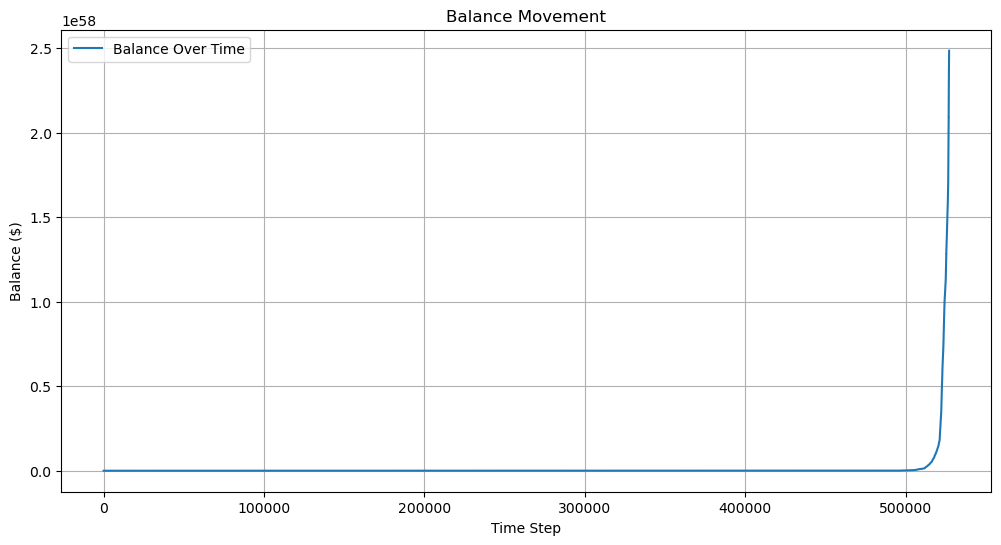

Initial Balance with 1h data: $1000.00
Final Balance with 1h data: $24836046364542387232320122724051307182830325082156433408000.00
Final Return with 1h data: 2483604636454238723232012272405130718283032508215643340800.00[%]


In [55]:
# Backtest the strategy
def backtest_with_plot(data, initial_balance=1000):
    # print(f"Initial Balance: ${initial_balance:.2f}")
    
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    balance_history = [initial_balance]  # Track balance over time
    
    for i in range(1, len(data)):
        if data['target'].iloc[i] == 1 and balance > 0:  # Buy signal
            position = balance / data['close'].iloc[i]
            balance = 0
        # elif data['target'].iloc[i] == -1 and position > 0:  # Sell signal
        elif data['target'].iloc[i] == 0 and position > 0:  # Sell signal
            balance = position * data['close'].iloc[i]
            position = 0
        # Record the current balance (including current position value)
        current_balance = balance + (position * data['close'].iloc[i])
        balance_history.append(current_balance)
    
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    # print(f"Final Balance: ${final_balance:.2f}")

    # Plot the balance history
    plt.figure(figsize=(12, 6))
    plt.plot(balance_history, label="Balance Over Time")
    plt.title("Balance Movement")
    plt.xlabel("Time Step")
    plt.ylabel("Balance ($)")
    plt.legend()
    plt.grid()
    plt.show()

    return final_balance

timeframe = '1h'
results = {}
initial_balance = 1000
final_balance = backtest_with_plot(btc_price_data_1_year, initial_balance)
results[timeframe] = final_balance

# Print results
print(f"Initial Balance with {timeframe} data: ${initial_balance:.2f}")

for timeframe, balance in results.items():
    print(f"Final Balance with {timeframe} data: ${balance:.2f}")
    final_return = ((balance - 1000) / 1000) * 100
    print(f"Final Return with {timeframe} data: {final_return:.2f}[%]")

In [56]:
btc_price_data_1_year.target.value_counts()

target
0    264745
1    262370
Name: count, dtype: int64

**Interpretation of the Backtest**

We have tested our trading strategy for the whole year with **1000** dollars initial capital. The **target** variable has **1366 buy signals** and **1482 sell signals**. The remaining **524.266** values are **0 (do nothing)**.

We always invested everything when we got a buy signal and had money and sold everything when we got a sell signal and had Bitcoin.
At the end of the backtest we had **\$2694,87** or **\$1694,87** (**169,49%**) profit.

## 9. Data Preprocessing for the Predictive Model

### 9.1. Split the Dataset

Typically, for time series, the data is split chronologically to avoid data leakage. For example:
- **Training set**: 70% of the data (used for training the model).
- **Validation set**: 15% of the data (used for hyperparameter tuning).
- **Test set**: 15% of the data (used to evaluate final performance).

In [57]:
# Sort the dataset by time to maintain chronological order
# btc_price_data_1_year = btc_price_data_1_year.sort_values(by='timestamp')  # Replace 'timestamp' with your time column if named differently

# Split the dataset into train, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Compute split indices
train_idx = int(len(btc_price_data_1_year) * train_size)
val_idx = int(len(btc_price_data_1_year) * (train_size + val_size))

# Split the data
btc_price_data_1_year_train = btc_price_data_1_year[:train_idx]
btc_price_data_1_year_val = btc_price_data_1_year[train_idx:val_idx]
btc_price_data_1_year_test = btc_price_data_1_year[val_idx:]

print(f"Training set: {len(btc_price_data_1_year_train)} rows")
print(f"Validation set: {len(btc_price_data_1_year_val)} rows")
print(f"Test set: {len(btc_price_data_1_year_test)} rows")

Training set: 368980 rows
Validation set: 79067 rows
Test set: 79068 rows


In [58]:
def plot_splitted_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    # x_lim_start = dates[0][0]
    # x_lim_end = dates[1][len(dates[1]) - 1]
    # # x_lim_end = dates[len(dates[0]) + len(dates[1]) - 1]
    # # plt.xlim(x_lim_start, x_lim_end)
    # ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates[0], prices[0], label ='Train Data')
    plt.plot(dates[1], prices[1], label ='Validation Data')
    plt.plot(dates[2], prices[2], label ='Test Data')
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.legend()
    plt.show()

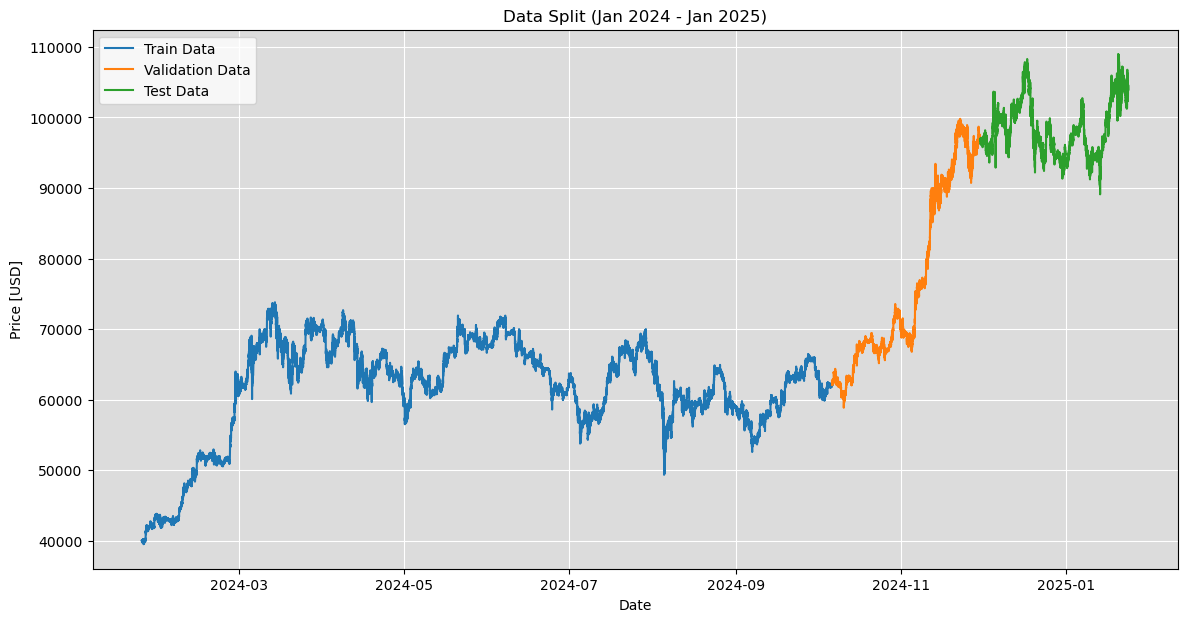

In [59]:
dates_train = btc_price_data_1_year_train.index
prices_close_train = btc_price_data_1_year_train.close

dates_val = btc_price_data_1_year_val.index
prices_close_val = btc_price_data_1_year_val.close

dates_test = btc_price_data_1_year_test.index
prices_close_test = btc_price_data_1_year_test.close

dates = [dates_train, dates_val, dates_test]
prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

title_btc = 'Data Split (Jan 2024 - Jan 2025)'

labels = ['Date', 'Price [USD]']

plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

### 9.2. Scale Features

1. Define the features to scale (numerical columns).
2. Fit the scaler on the **training set** only.
3. Apply the transformation to training, validation, and test sets.

In [60]:
# Exclude already normalized features like 'hour_sin'/'hour_cos'
features_to_exclude = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
# Exclude already normalized features like 'hour_sin'/'hour_cos' and the 'target'('target' is categorical variable)
# features_to_exclude = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'target']

# Select the remaining columns
features_to_scale = [col for col in btc_price_data_1_year.columns if col not in features_to_exclude]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training set and transform all sets
btc_price_data_1_year_train.loc[:, features_to_scale] = scaler.fit_transform(btc_price_data_1_year_train[features_to_scale])
btc_price_data_1_year_val.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_val[features_to_scale])
btc_price_data_1_year_test.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_test[features_to_scale])

### 9.3. Prepare Features and Targets

Separate the features and target variables for our LSTM model.

In [61]:
# Define features and target
# not_scaled_features = [x for x in features_to_exclude if x != 'target']
# Remove the 'target' feature from 'features_to_scale'
features_to_scale_cleaned = [x for x in features_to_scale if x != 'target']

X_train = btc_price_data_1_year_train[features_to_scale_cleaned + features_to_exclude].values
y_train = btc_price_data_1_year_train['target'].values

X_val = btc_price_data_1_year_val[features_to_scale_cleaned + features_to_exclude].values
y_val = btc_price_data_1_year_val['target'].values

X_test = btc_price_data_1_year_test[features_to_scale_cleaned + features_to_exclude].values
y_test = btc_price_data_1_year_test['target'].values

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (368980, 58), y_train shape: (368980,)
X_val shape: (79067, 58), y_val shape: (79067,)
X_test shape: (79068, 58), y_test shape: (79068,)


### 9.4. Reshape Data for LSTM

LSTMs require input data in the shape of `(samples, sequence_length, num_features)`. For time series data, you typically convert the flat features into sequences.

In [62]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])  # Last `timesteps` rows
        y_seq.append(y[i])             # Corresponding target
    return np.array(X_seq), np.array(y_seq)

In [63]:
# Define the number of timesteps (sequence length) for LSTM
timesteps = 50  # Using the last 50 hours to predict the target

# Create sequences for training, validation, and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (368956, 24, 58), y_train_seq shape: (368956,)
X_val_seq shape: (79043, 24, 58), y_val_seq shape: (79043,)
X_test_seq shape: (79044, 24, 58), y_test_seq shape: (79044,)


## 10. Define Model Architecture

### 10.1. Model Definition

### **TODO** - create a model description
Let’s use a hybrid CNN + LSTM architecture for time-series forecasting.

In [85]:
def build_model(sequence_length, num_features):
    # Input layer
    input_layer = Input(shape=(sequence_length, num_features))
    
    # CNN for feature extraction
    cnn_layer = Conv1D(filters = 32, kernel_size = 3, activation='relu')(input_layer)
    cnn_layer = MaxPooling1D(pool_size = 2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    
    # LSTM for temporal dependencies
    # lstm_layer = LSTM(64, return_sequences=False)(input_layer)

    # LSTM for temporal dependencies
    lstm_layer = LSTM(64, return_sequences=True)(input_layer)
    attention_output = Attention()([lstm_layer, lstm_layer])  # Self-attention mechanism
    lstm_output = Flatten()(attention_output)
    
    # Combine CNN and LSTM outputs
    combined = Concatenate()([cnn_layer, lstm_output])
    
    # Fully connected layers
    dense_layer = Dense(128, activation='relu')(combined)
    dense_layer = Dropout(0.2)(dense_layer)
    dense_layer = Dense(64, activation='relu')(dense_layer)

    # Output layer (regression)
    output_layer = Dense(1, activation='linear')(dense_layer)
    
    # Build and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [115]:
def build_model_classifcation(sequence_length, num_features):
    # LSTM Input
    lstm_input = Input(shape=(sequence_length, num_features))
    
    # LSTM Layers
    x = LSTM(64, return_sequences=True)(lstm_input)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    
    # Fully Connected Layer
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    
    # Output Layer - Probability of Price Going Up
    output = Dense(1, activation="sigmoid")(x)  # Probability between 0 and 1
    
    # Define Model
    model = tf.keras.Model(inputs=lstm_input, outputs=output)
    
    # Compile Model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

### 10.2. Initialize the Model

In [116]:
sequence_length = X_train_seq.shape[1]  # Length of the sequences (e.g., 24 hours)
num_features = X_train_seq.shape[2]  # Number of features in the dataset

model = build_model(sequence_length, num_features)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 24, 58)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 64)              │          31,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,993 (175.75 KB)

 Trainable params: 44,993 (175.75 KB)

 Non-trainable params: 0 (0.00 B)

### 10.3. Train the Model

Set up training parameters and callbacks to monitor performance.

**Early Stopping** prevents overfitting by stopping training when the validation performance stops improving.

In [117]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# EarlyStopping(monitor='val_loss', patience=20)

Save the best model

In [118]:
filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'
# filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{accuracy:.4f}-{val_accuracy:.4f}.hdf5'
cp = ModelCheckpoint(f'{filepath}.keras', save_best_only = True)
#cp = ModelCheckpoint('model/model1.keras', save_best_only = True, monitor = "loss", mode = 'mean')

In [119]:
# filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'

# callbacks = [EarlyStopping(monitor='val_loss', patience=20),
#              ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

**Train the model** with your training data, using validation data to track performance.

In [120]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs = 5,  # You can adjust this
    batch_size = 32,  # Experiment with batch sizes
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, cp],
    verbose=1
)

Epoch 1/5
11530/11530 ━━━━━━━━━━━━━━━━━━━━ 215s 18ms/step - accuracy: 0.5009 - loss: 0.6937 - val_accuracy: 0.5025 - val_loss: 0.6931
Epoch 2/5
11530/11530 ━━━━━━━━━━━━━━━━━━━━ 204s 18ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.5025 - val_loss: 0.6932
Epoch 3/5
11530/11530 ━━━━━━━━━━━━━━━━━━━━ 202s 18ms/step - accuracy: 0.5012 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6931
Epoch 4/5
11530/11530 ━━━━━━━━━━━━━━━━━━━━ 201s 17ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5025 - val_loss: 0.6931
Epoch 5/5
11530/11530 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.4975 - val_loss: 0.6932


In [121]:
# Load the best model
model = load_model('model/model1.keras')

### 10.4. Evaluate the Model

Evaluate the model on the test set to see how well it generalizes.

In [122]:
def plot_prictions(predictions, actual_values, labels):
    # Plot predictions 
    plt.figure(figsize=(10, 6))
    plt.plot(predictions, label = labels[0])
    plt.plot(actual_values, label = labels[1])
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{labels[0]} vs. {labels[1]}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Evaluate with Test Data

In [123]:
# Predictions on the test data
y_pred_test = model.predict(X_test_seq)

# Metrics
mse = mean_squared_error(y_test_seq, y_pred_test)
mae = mean_absolute_error(y_test_seq, y_pred_test)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

In [124]:
# # Evaluate performance (Classification)
# loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
# print(f"Test Accuracy: {accuracy:.4f}")

# # Predict probabilities
# y_pred_prob_test = model.predict(X_test_seq)
# y_pred_test = (y_pred_prob_test > 0.5).astype(int)

2471/2471 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.1688 - mae: 0.9554
Test Accuracy: 0.9601
2471/2471 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


In [125]:
test_pred = y_pred_test.flatten()
y_pred_test = y_test_seq.flatten()

test_results = pd.DataFrame(data = {'Test Predictions': test_pred, 'Actuals': y_pred_test})
test_results

,Test Predictions,Actuals
0,1,1
1,1,0
2,1,1
3,1,0
4,1,1
...,...,...
79039,1,0
79040,1,0
79041,1,0
79042,1,0


In [126]:
test_results['Test Predictions'].value_counts()

Test Predictions
1    79044
Name: count, dtype: int64

In [127]:
test_results['Actuals'].value_counts()

Actuals
0    39944
1    39100
Name: count, dtype: int64

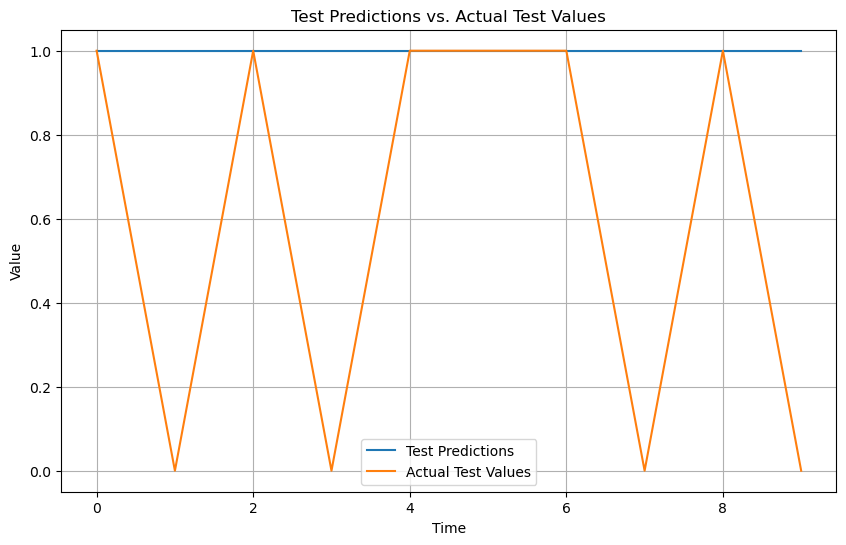

In [128]:
# Plot the predictions
labels = ['Test Predictions', 'Actual Test Values']
plot_prictions(test_results['Test Predictions'][:10], test_results['Actuals'][:10], labels)

#### Evaluate with Validate Data

In [75]:
# Predictions on the test data
y_pred_val = model.predict(X_val_seq)

# Metrics
mse = mean_squared_error(y_val_seq, y_pred_val)
mae = mean_absolute_error(y_val_seq, y_pred_val)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

2471/2471 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Mean Squared Error (MSE): 0.5363698601722717
Mean Absolute Error (MAE): 0.6155533790588379


In [76]:
val_pred = y_pred_val.flatten()
y_pred_val = y_val_seq.flatten()

val_results = pd.DataFrame(data = {'Test Predictions': val_pred, 'Actuals': y_pred_val})
val_results

,Test Predictions,Actuals
0,0.587706,0
1,0.587020,1
2,0.586684,1
3,0.586887,1
4,0.589005,1
...,...,...
79038,1.416046,0
79039,1.416192,0
79040,1.417263,0
79041,1.416948,0


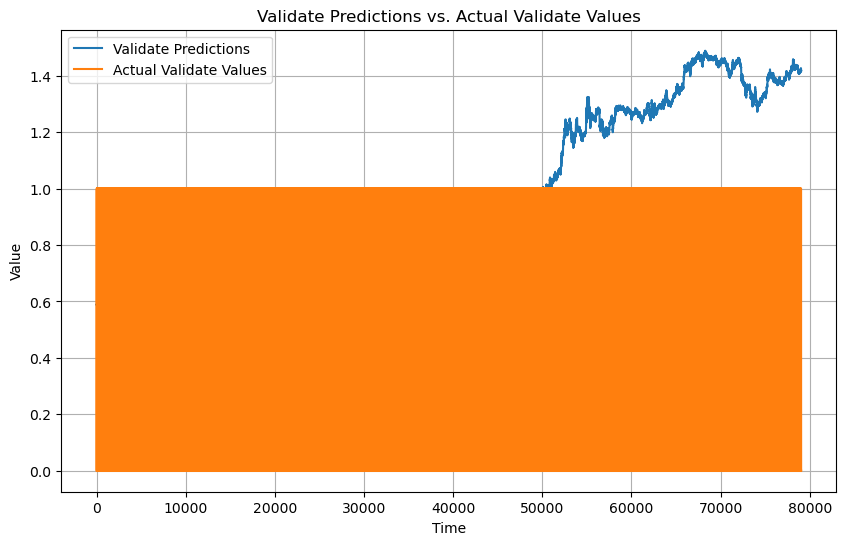

In [77]:
# Plot the predictions
labels = ['Validate Predictions', 'Actual Validate Values']
plot_prictions(val_results['Test Predictions'], val_results['Actuals'], labels)

#### Evaluate with Train Data

In [78]:
# Predictions on the Train Data
y_pred_train = model.predict(X_train_seq)

# Metrics
mse_train = mean_squared_error(y_train_seq, y_pred_train)
mae_train = mean_absolute_error(y_train_seq, y_pred_train)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")

11530/11530 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step
Mean Squared Error (MSE): 0.286196231842041
Mean Absolute Error (MAE): 0.5015008449554443


In [79]:
train_pred = y_pred_train.flatten()
y_pred_train = y_train_seq.flatten()

train_results = pd.DataFrame(data = {'Train Predictions': train_pred, 'Actuals': y_pred_train})
train_results

,Train Predictions,Actuals
0,0.047171,0
1,0.046961,0
2,0.046729,0
3,0.046503,1
4,0.046218,0
...,...,...
368951,0.589329,1
368952,0.589234,0
368953,0.589032,1
368954,0.588208,0


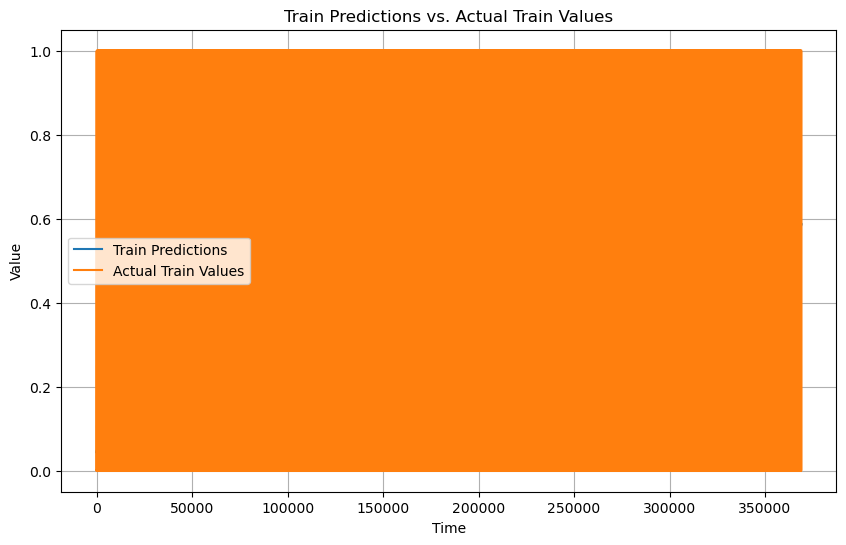

In [80]:
# Plot the predictions
labels = ['Train Predictions', 'Actual Train Values']
plot_prictions(train_results['Train Predictions'], train_results['Actuals'], labels)

### 10.5. Forecast Future Prices

Once the model is trained, you can use it to forecast future prices.

In [77]:
# Prepare a sequence of the last 24 hours
latest_sequence = X_test_seq[-1].reshape(1, sequence_length, num_features)

# Predict the next hour's price
next_price_scaled = model.predict(latest_sequence)
print(f"Predicted next price: {next_price_scaled[0][0]}")

# Prepare the input with the same number of features
predicted_full_features = np.zeros((1, 55))  # Assuming 55 features in the original scaler
predicted_full_features[:, -1] = next_price_scaled[0][0]  # Insert the predicted price

# Inverse transform
next_price_original_full = scaler.inverse_transform(predicted_full_features)

# Extract the original price
next_price_original = next_price_original_full[0, -1]
print(f"Predicted next price (original scale): {next_price_original}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted next price: 1.5917977094650269
Predicted next price (original scale): 94103.40948599456


Here’s a step-by-step guide on how to use your prepared dataset for training a neural network and tuning hyperparameters:

---
### **Step 6: Hyperparameter Tuning**
To tune hyperparameters, you can use tools like **Keras Tuner** or manually adjust parameters in a structured way.

### Option 1: Grid Search (Manual)
Manually try different combinations of hyperparameters:
- **Number of filters in CNN (e.g., 16, 32, 64).**
- **LSTM units (e.g., 32, 64, 128).**
- **Batch size (e.g., 16, 32, 64).**
- **Learning rate (e.g., 0.001, 0.0001).**
- **Dropout rate (e.g., 0.2, 0.3, 0.4).**

Example:
```python
for filters in [16, 32, 64]:
    for lstm_units in [32, 64, 128]:
        model = build_model(sequence_length, num_features)
        print(f"Training with filters={filters}, lstm_units={lstm_units}")
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
```

---

### Option 2: Keras Tuner (Automated)
Use **Keras Tuner** to automate hyperparameter tuning.

```python
import keras_tuner as kt

# Define a model-building function for Keras Tuner
def build_tuned_model(hp):
    input_layer = Input(shape=(sequence_length, num_features))
    
    # CNN
    cnn_layer = Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=64, step=16), 
        kernel_size=3, activation='relu'
    )(input_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    
    # LSTM
    lstm_layer = LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
        return_sequences=False
    )(input_layer)
    
    # Combine
    combined = Concatenate()([cnn_layer, lstm_layer])
    dense_layer = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64), 
        activation='relu'
    )(combined)
    dense_layer = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(dense_layer)
    output_layer = Dense(1, activation='linear')(dense_layer)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='mse',
        metrics=['mae']
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_tuned_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuning_dir',
    project_name='bitcoin_forecasting'
)

# Run the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")
```

---

### **Step 7: Save and Load the Model**
Save the best model for future use.

```python
# Save model
model.save('bitcoin_price_model.h5')

# Load model
from tensorflow.keras.models import load_model
model = load_model('bitcoin_price_model.h5')
```

---

### **Step 8: Forecast Future Prices**
Once the model is trained, you can use it to forecast future prices.

```python
# Prepare a sequence of the last 24 hours
latest_sequence = X_test[-1].reshape(1, sequence_length, num_features)

# Predict the next hour's price
next_price = model.predict(latest_sequence)
print(f"Predicted next price: {next_price[0][0]}")
```

---

This approach allows you to train, evaluate, and tune your model effectively. Let me know if you need more help!